In [2]:
from scipy.stats import bernoulli

# Task 1
Reproduce Figure 1 from (Candès et al. 2018). [20 points]

Use this version of the paper: https://arxiv.org/abs/1610.02351.

## Figure 1 - left part

### Sklearn coefficient p-values vs statsmodels

Based of: https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance

In [2]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
x = np.arange(10)[:, np.newaxis]
y = np.array([0,0,0,1,0,0,1,1,1,1])
model = LogisticRegression(C=1e30).fit(x, y)
print(logit_pvalue(model, x))

# compare with statsmodels
import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

[0.11413171 0.08780382]
[0.11413093 0.08779979]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                          Logit   Df Residuals:                        8
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Mar 2024   Pseudo R-squ.:                  0.4856
Time:                        21:55:30   Log-Likelihood:                -3.5656
converged:                       True   LL-Null:                       -6.9315
Covariance Type:            nonrobust   LLR p-value:                  0.009472
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9587      2.506     -1.580      0.114      -8.870       0.952
x1             0.8797      0.515      1.707      0.088      -0.130       1.890
==============================================================================
"""

### Statmodels

#### Average

100%|██████████| 10000/10000 [26:01<00:00,  6.40it/s] 


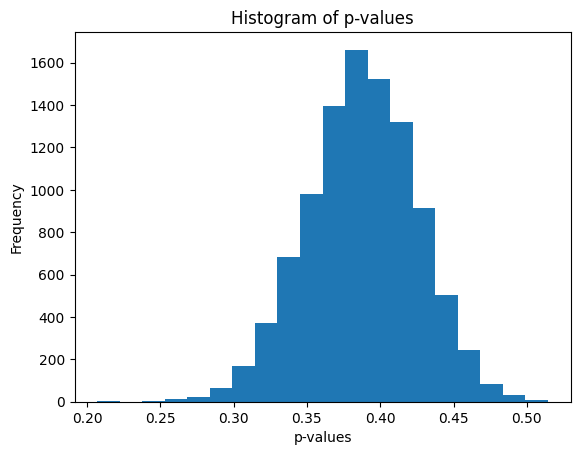

In [1]:
from scipy.stats import bernoulli
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
import numpy as np


# Set the AR coefficient
ar_coefficient = 0.5
p = 200
n = 500
replications = 10000

# Calculate the p-values for each run
p_values = []
for i in tqdm(range(replications)):
    # Generate the AR(1) time series
    ar_process = ArmaProcess(ar=[1, -ar_coefficient])

    X = []
    for j in range(n):
        time_series = ar_process.generate_sample(nsample=p)
        X.append(time_series)

    y = bernoulli.rvs(p=0.5, size=n)

    #sm_model = Logit(y, X).fit(disp=0) #like 1h?
    sm_model = Logit(y, add_constant(X)).fit(disp=0) #like 30min
    p_value = np.average(sm_model.pvalues)
    p_values.append(p_value)

# Show a histogram of the p-values
plt.hist(p_values, bins=20) #paper has 20 bins
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of p-values')
plt.show()

#### Sperate terms

In [2]:
from scipy.stats import bernoulli
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

np.random.seed(21)

# Set the AR coefficient
ar_coefficient = 0.5
p = 200
n = 500
replications = 10000

intercept_p_values = []
x1_data_p_values = []

# Generate the AR(1) time series
ar_process = ArmaProcess(ar=[1, -ar_coefficient])

# Calculate the p-values for each run
for i in tqdm(range(replications)):

    X = []
    for j in range(n):
        time_series = ar_process.generate_sample(nsample=p)
        X.append(time_series)

    y = bernoulli.rvs(p=0.5, size=n)

    #sm_model = Logit(y, X).fit(disp=0) #like 1h?
    sm_model = Logit(y, add_constant(X)).fit(disp=0) #like 30min
    intercept_p_values.append(sm_model.pvalues[0])
    x1_data_p_values.append(sm_model.pvalues[1])

df = pd.DataFrame({"intercept p-values": intercept_p_values, "x1 p-values": x1_data_p_values})

df.to_csv("p_values.csv", index=False)

100%|██████████| 10000/10000 [34:59<00:00,  4.76it/s] 


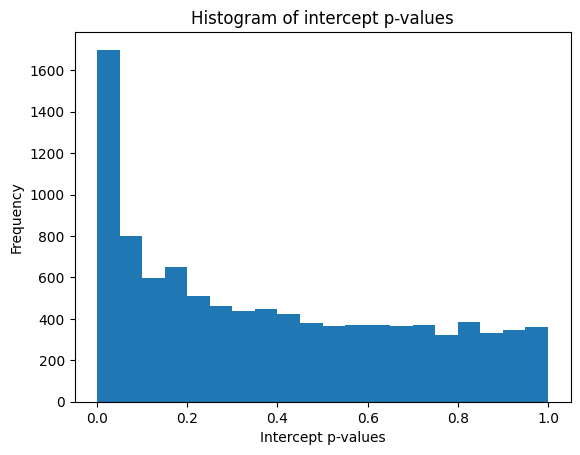

In [3]:
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(df["intercept p-values"], bins=20) #paper has 20 bins
plt.xlabel('Intercept p-values')
plt.ylabel('Frequency')
plt.title('Histogram of intercept p-values')
plt.show()

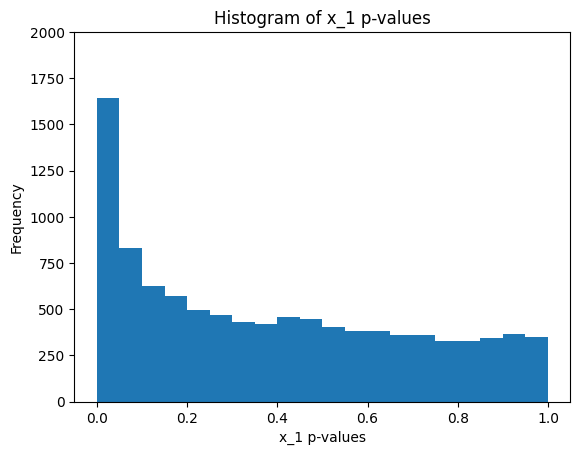

In [5]:
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(df['x1 p-values'], bins=20) #paper has 20 bins
plt.xlabel('x_1 p-values')
plt.ylabel('Frequency')
plt.ylim((0, 2000))
plt.title('Histogram of x_1 p-values')
plt.show()

### Loading generated p-values

In [1]:
import pandas as pd

df = pd.read_csv("p_values.csv")

In [2]:
df

,intercept p-values,x1 p-values
0,0.391406,0.790353
1,0.437404,0.023153
2,0.463677,0.893404
3,0.840421,0.475078
4,0.951833,0.000407
...,...,...
9995,0.675893,0.138250
9996,0.026954,0.032387
9997,0.039965,0.145917
9998,0.749626,0.663526


## Task 1 - right part

In [4]:
import numpy as np
from scipy.special import logit, expit


def probability(X_non_zero):
    assert len(X_non_zero) == 20
    p = 0.08*np.sum(X_non_zero)
    return expit(p)
    #return logit(-p)
    #return 1/(1+np.exp(-p))
    #return np.log(p/(1-p))

In [31]:
from scipy.stats import bernoulli
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

np.random.seed(21)

# Set the AR coefficient
ar_coefficient = 0.5
p = 200
n = 500
replications = 10000

intercept_p_values = []
x1_data_p_values = []

# Generate the AR(1) time series
ar_process = ArmaProcess(ar=[1, -ar_coefficient])

# Calculate the p-values for each run
for i in tqdm(range(replications)):

    X = []
    y = []
    for j in range(n):
        time_series = ar_process.generate_sample(nsample=p)
        X.append(time_series)

        prob = probability(time_series[2:22])
        #print(prob)
        y_observation = bernoulli.rvs(p=prob)
        y.append(y_observation)

    try:
        sm_model = Logit(y, add_constant(X)).fit(disp=0) #like 30min
        intercept_p_values.append(sm_model.pvalues[0])
        x1_data_p_values.append(sm_model.pvalues[1])
    except Exception as e:
        continue

df = pd.DataFrame({"intercept p-values": intercept_p_values, "x1 p-values": x1_data_p_values})

df.to_csv("p_values_right.csv", index=False)

  0%|          | 3/10000 [00:00<32:07,  5.19it/s]/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
  4%|▎         | 372/10000 [01:27<37:52,  4.24it/s]  


KeyboardInterrupt: 

In [27]:
1/(1+np.exp(5.5987))

0.003689014845767509

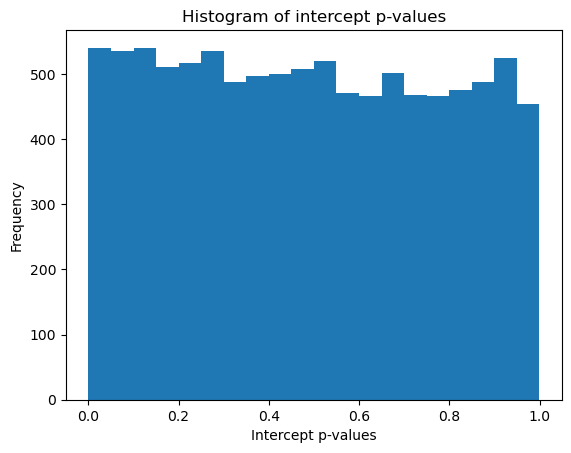

In [13]:
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(intercept_p_values, bins=20) #paper has 20 bins
plt.xlabel('Intercept p-values')
plt.ylabel('Frequency')
plt.title('Histogram of intercept p-values')
plt.show()

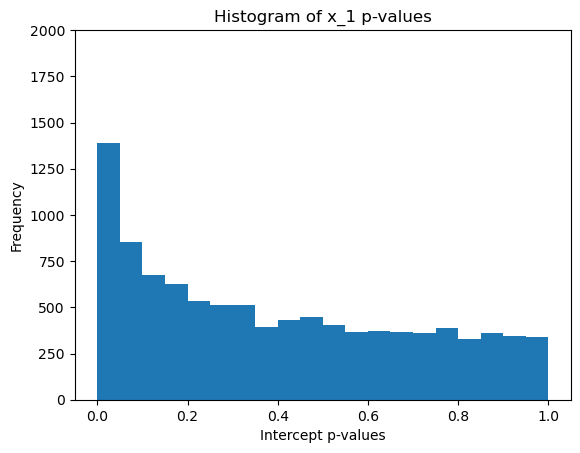

In [14]:
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(x1_data_p_values, bins=20) #paper has 20 bins
plt.xlabel('x_1 p-values')
plt.ylabel('Frequency')
plt.title('Histogram of x_1 p-values')
plt.ylim((0, 2000))
plt.show()

In [1]:
import pandas as pd

df = pd.read_csv("p_values_right.csv")

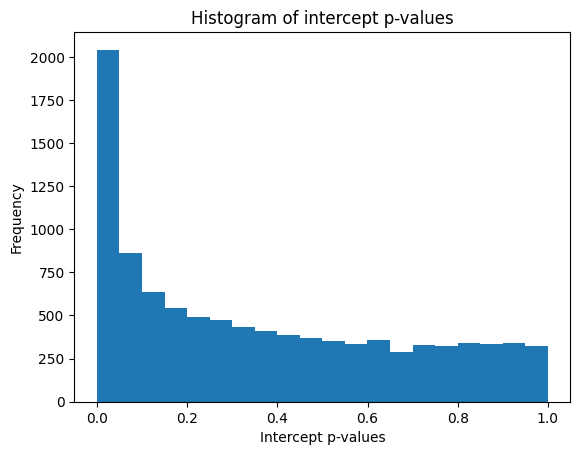

In [2]:
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(df['intercept p-values'], bins=20) #paper has 20 bins
plt.xlabel('Intercept p-values')
plt.ylabel('Frequency')
plt.title('Histogram of intercept p-values')
plt.show()

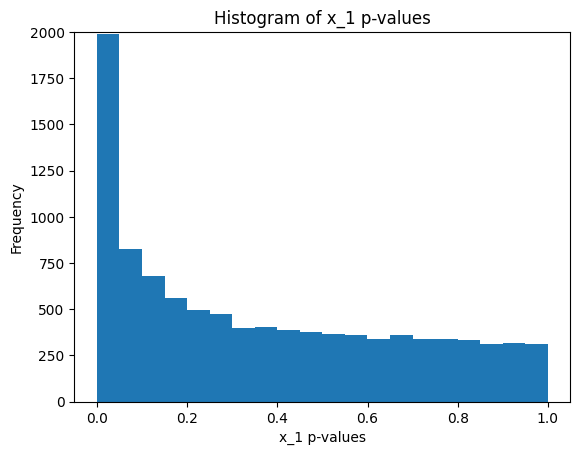

In [3]:
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(df['x1 p-values'], bins=20) #paper has 20 bins
plt.xlabel('x_1 p-values')
plt.ylabel('Frequency')
plt.title('Histogram of x_1 p-values')
plt.ylim((0, 2000))
plt.show()

### Task 3

Propose a solution to address the problem. You can implement conditional randomization test (Candès et al. 2018), another existing method, or come up with your own idea.

Rejections 8


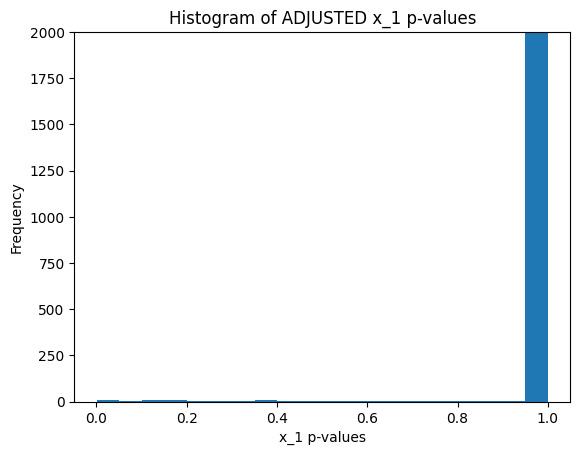

In [54]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

#multipletests(pvals, alpha=0.05, method='hs', maxiter=1, is_sorted=False, returnsorted=False)
reject, pvals_corrected, alphacSidak, alphacBonf= multipletests(df['x1 p-values'].values, method='bonferroni', is_sorted=False)
#reject, pvals_corrected, alphacSidak, alphacBonf= multipletests(df['x1 p-values'].values, method='sidak', is_sorted=False)
#reject, pvals_corrected, alphacSidak, alphacBonf= multipletests(df['x1 p-values'].values, method='holm-sidak', is_sorted=False)
#reject, pvals_corrected, alphacSidak, alphacBonf= multipletests(df['x1 p-values'].values, method='holm', is_sorted=False)


print('Rejections', np.sum(reject))

# Show a histogram of the p-values
plt.hist(pvals_corrected, bins=20) #paper has 20 bins
plt.xlabel('x_1 p-values')
plt.ylabel('Frequency')
plt.title('Histogram of ADJUSTED x_1 p-values')
plt.ylim((0, 2000))
plt.show()

In [1]:
import random
#from sklearn.feature_selection import mutual_info_classif

def test_statistic(X, y):
    matrix_multiplication = np.transpose(X) @ y
    #matrix_multiplication = np.matmul(np.transpose(X), y)
    return matrix_multiplication

#def test_statistic(X, y):
#    mi_scores = mutual_info_classif(X, y)
#    return mi_scores



def adjusted_p_value(X, y, test_statistic, j, K):
    X = np.array(X)
    org_X = X.copy()
    summation = []
    for k in range(K):
        for n in range(X.shape[0]):
            possible_samples = np.append(X[n][:j], X[n][j+1:])
            #print(possible_samples.size) == 199
            sample = random.choice(possible_samples)
            X[n][j] = sample

        #print(test_statistic(X, y) > test_statistic(org_X, y))
        summation.append(1 if np.sum(test_statistic(X, y)) > np.sum(test_statistic(org_X, y)) else 0)
        #summation.append(1 if test_statistic(X, y)[j] > test_statistic(org_X, y)[j] else 0)
    adjusted_p_value = 1/(K+1) * (1 + np.sum(summation))

    return adjusted_p_value

In [5]:
from scipy.stats import bernoulli
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

np.random.seed(21)

# Set the AR coefficient
ar_coefficient = 0.5
p = 200
n = 500
replications = 500
K = 10

#intercept_p_values = []
#x1_data_p_values = []
p_values = []

# Generate the AR(1) time series
ar_process = ArmaProcess(ar=[1, -ar_coefficient])

# Calculate the p-values for each run
for i in tqdm(range(replications)):

    X = []
    for j in range(n):
        time_series = ar_process.generate_sample(nsample=p)
        X.append(time_series)

    y = bernoulli.rvs(p=0.5, size=n)

    for feature in range(p):
        p_values_adjusted = adjusted_p_value(X, y, test_statistic, feature, K)
        p_values.append(p_values_adjusted)

df = pd.DataFrame({"adjusted p-values": p_values})

df.to_csv("p_values_adj.csv", index=False)

100%|██████████| 500/500 [47:36<00:00,  5.71s/it]


In [6]:
len(p_values)

100000

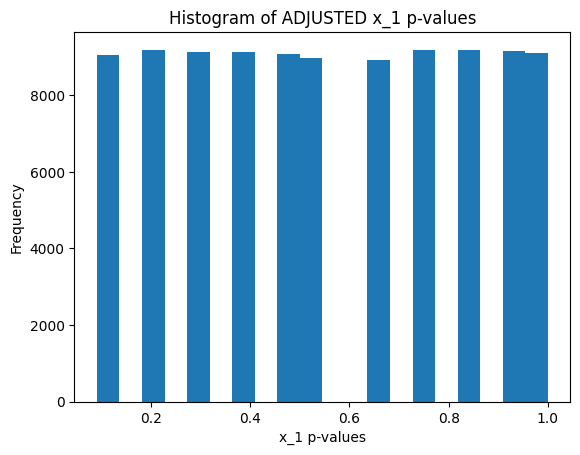

In [11]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(p_values, bins=20) #paper has 20 bins
plt.xlabel('x_1 p-values')
plt.ylabel('Frequency')
plt.title('Histogram of ADJUSTED x_1 p-values')
#plt.ylim((0, 2000))
plt.show()